## Magnetic Model Comparison

This notebook compares the CHAOS-6-Core models evaluated by two different implementations:

- [eoxmagmod](https://github.com/ESA-VirES/MagneticModel/tree/staging/eoxmagmod) (used by VirES)
- [chaosmagpy](http://www.spacecenter.dk/files/magnetic-models/CHAOS-6/) (reference Python implementation)


This version of the notebook corrects the error caused by the different decimal year/MJD2000 conversions:

- The `eoxmagmod` library converts the decimal year to MJD2000 so that a whole decimal year is always aligned with the midnight 1st of January.

- The `chaosmagpy` calculates the MJD2000 as $t_\text{MJD200} = 365.25 \times (t_\text{decimal year} - 2000)$

This version redefines the `eoxmagmod` model to use the same conversion as the `chaosmagpy` package.

In [1]:
from numpy import asarray

def decimal_year_to_mjd2000(decimal_year):
    return (asarray(decimal_year) - 2000) * 365.25

def mjd2000_to_decimal_year(mjd2000):
    return 2000.0 + asarray(mjd2000) / 365.25

### 1) load SHC model file

In [2]:
from os.path import basename
from eoxmagmod.data import CHAOS6_CORE_LATEST

print(basename(CHAOS6_CORE_LATEST))
print(open(CHAOS6_CORE_LATEST).read())

CHAOS-6-x7_core.shc
# CHAOS-6-x7 core field model                      
# Based on model iteration_1 of CF_CHAOS_09d_18.mat
# extracted on 09-Oct-2018 12:11:25                
  1  20 221   6   5
          1997.1020   1997.2019   1997.3018   1997.4018   1997.5017   1997.6016   1997.7016   1997.8015   1997.9014   1998.0014   1998.1013   1998.2012   1998.3012   1998.4011   1998.5010   1998.6010   1998.7009   1998.8008   1998.9008   1999.0007   1999.1006   1999.2005   1999.3005   1999.4004   1999.5003   1999.6003   1999.7008   1999.8012   1999.9017   2000.0022   2000.1027   2000.2026   2000.3025   2000.4025   2000.5024   2000.6023   2000.7023   2000.8022   2000.9021   2001.0021   2001.1020   2001.2019   2001.3018   2001.4018   2001.5017   2001.6016   2001.7016   2001.8015   2001.9014   2002.0014   2002.1013   2002.2012   2002.3012   2002.4011   2002.5010   2002.6010   2002.7009   2002.8008   2002.9008   2003.0007   2003.1006   2003.2005   2003.3005   2003.4004   2003.5003   2003.6003   20

/usr/local/conda/lib/python3.7/site-packages/spacepy/pycdf/__init__.py:1209: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class CDF(collections.MutableMapping):


### 2) generate times and locations

In [3]:
# generate random points
from math import pi
from numpy import sin, cos, dstack, linspace
from numpy.random import random, uniform

EARTH_RADIUS = 6371.2 # km
N_coords = 500

X = random((N_coords*2, 2))
X = X[X[..., 1] < sin(X[..., 0]*pi)][:N_coords, ...]
X[..., 0] = pi * (X[..., 0] - 0.5)
X[..., 1] = pi*(2.0*X[..., 1] / cos(X[..., 0]) - 1.0)
X *= 180./pi
lats = X[..., 0]
lons = X[..., 1]
rads = uniform(EARTH_RADIUS, 1.1*EARTH_RADIUS, N_coords)

coords = dstack((lats, lons, rads))[0]

In [4]:
#generate times
from eoxmagmod import load_model_shc
model_vires = load_model_shc(CHAOS6_CORE_LATEST)
#N_times = 500
#start, end = model_vires.validity
#times = linspace(start + 1, end - 1, num=N_times)
times = decimal_year_to_mjd2000(model_vires.coefficients._times)
N_times = len(times)

### 3) evaluate the VirES model

In [5]:
from numpy import empty
from eoxmagmod.magnetic_model.model import SphericalHarmomicGeomagneticModel
from eoxmagmod.magnetic_model.coefficients import SparseSHCoefficientsTimeDependent
from eoxmagmod.magnetic_model.util import parse_file
from eoxmagmod.magnetic_model.parser_shc import parse_shc_file

def load_coeff_shc_mjd2000(path):
    """ Load coefficients from an SHC file (interpolated in the MJD2000 time domain) """
    data = parse_file(parse_shc_file, path)
    options = {
        key: decimal_year_to_mjd2000(data[key])
        for key in ("validity_start", "validity_end") if key in data
    }
    times = data["t"]
    if len(times) == 1:
        return SparseSHCoefficientsConstant(
            data["nm"], data["gh"][:, 0], **options
        )
    else:
        return SparseSHCoefficientsTimeDependent(
            data["nm"], data["gh"], decimal_year_to_mjd2000(times), **options
        )

model_vires = SphericalHarmomicGeomagneticModel(
    load_coeff_shc_mjd2000(CHAOS6_CORE_LATEST)
)

b_nec_vires = empty((N_times, N_coords, 3))

for idx, time in enumerate(times):
    b_nec_vires[idx, ...] = model_vires.eval(time, coords, scale=[1, 1, -1])

### 4) evaluate the reference model

In [6]:
from chaosmagpy import load_CHAOS_shcfile
model_ref = load_CHAOS_shcfile(CHAOS6_CORE_LATEST)

b_nec_ref = empty((N_times, N_coords, 3))

for idx, time in enumerate(times):
    a, b, c = model_ref(time, rads, 90.0 - lats, lons, source_list=['tdep'])
    b_nec_ref[idx, :, 0] = -b
    b_nec_ref[idx, :, 1] = c
    b_nec_ref[idx, :, 2] = -a

Computing time-dependent internal field up to degree 20.
Finished in 0.012526 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118054 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117995 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118144 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118967 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116515 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118255 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118703 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0115056 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0115766 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120174 seconds.
Computing time-dependent internal

Finished in 0.0116736 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116913 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116725 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0115623 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116138 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.013184 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116885 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011706 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0115775 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116364 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116412 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116799 seconds.
Com

Finished in 0.0137511 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119662 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116997 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118482 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118938 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118142 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011677 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0115774 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120736 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118281 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0115717 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012125 seconds.
Com

### 5) model comparison

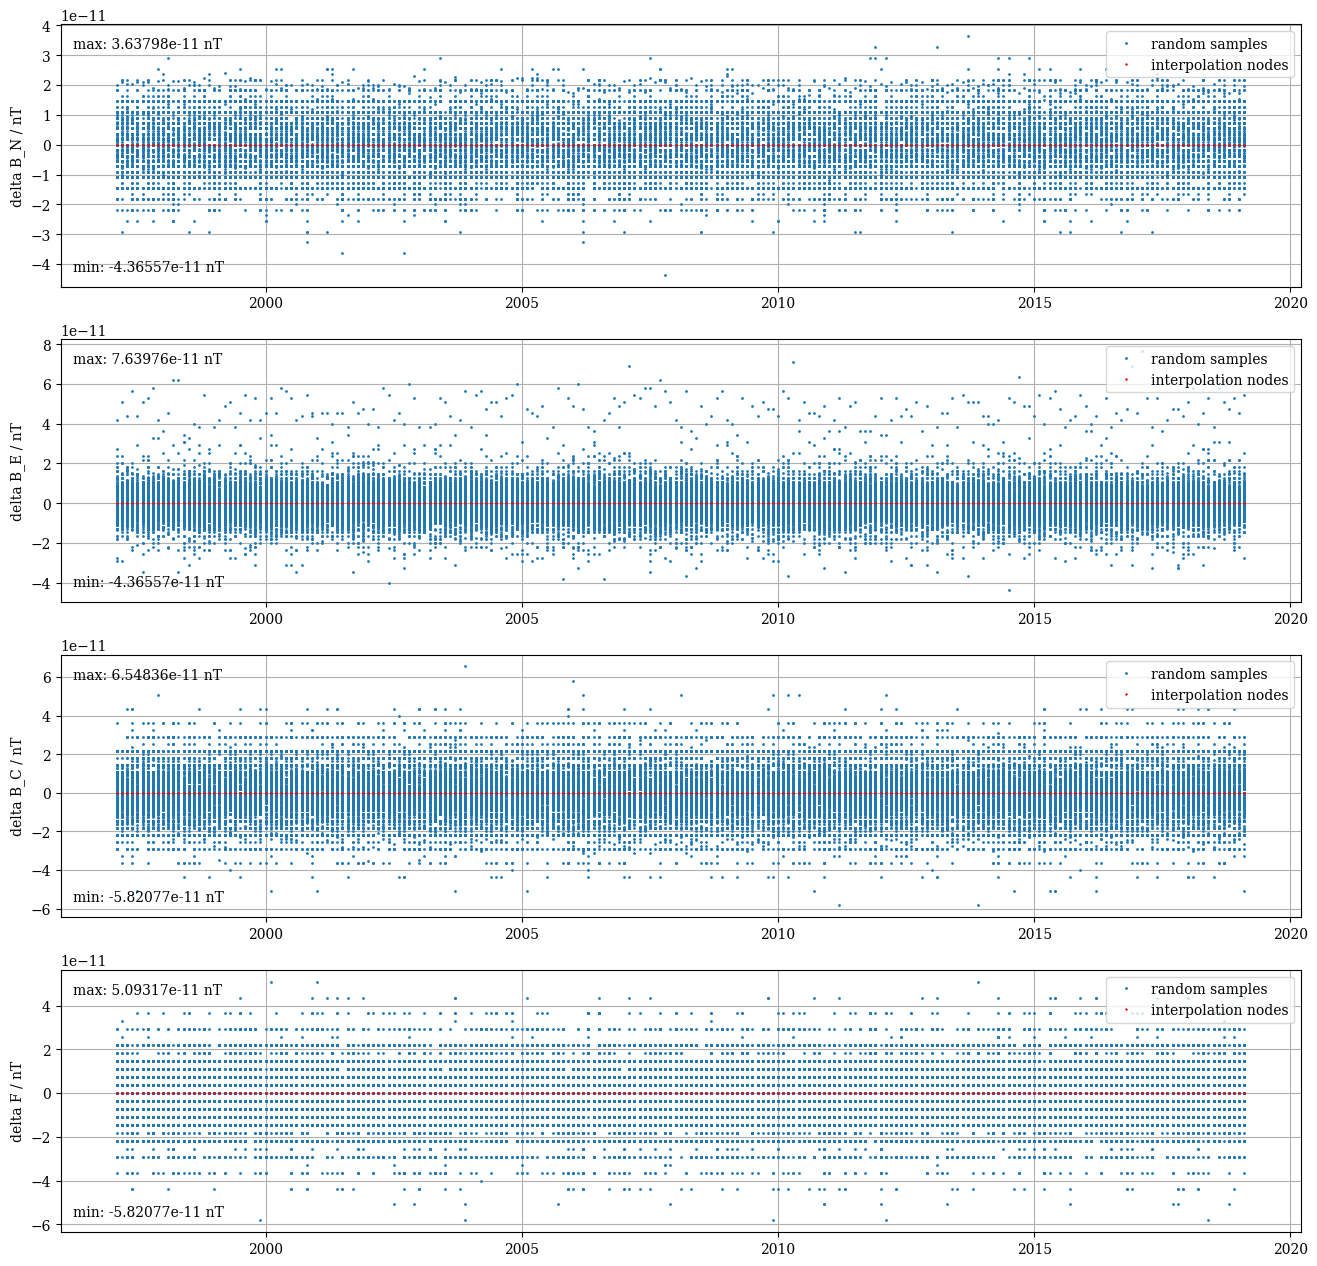

In [7]:
from numpy import zeros, concatenate, isnan
from matplotlib import pyplot as plt
from eoxmagmod import vnorm

node_times = mjd2000_to_decimal_year(model_vires.coefficients._times)
node_val = zeros(node_times.shape)

delta_b_nec = b_nec_vires - b_nec_ref
delta_f = vnorm(b_nec_vires) - vnorm(b_nec_ref)

fig = plt.figure(figsize=(16, 16), dpi=100)
plt.title("eoxmagmod vs chaosmagpy (CHAOS-6-Core, x7)")

times_dy = mjd2000_to_decimal_year(times)

def plot(ax, x0, y0, label):
    x, y = [], []
    for idx in range(0, N_coords):
        x.append(x0)
        y.append(y0[:, idx])
    x, y = concatenate(x), concatenate(y)
    plt.plot(x, y, '.', markersize=2, color='#1f77b4', label='random samples')
    plt.plot(node_times, node_val, '+r', markersize=2, label='interpolation nodes')
    plt.ylabel(label)
    plt.legend(loc='upper right')
    plt.text(
        0.01, 0.95, 'max: %g nT' % y[~isnan(y)].max(),
        horizontalalignment='left', verticalalignment='top', transform=ax.transAxes
    )
    plt.text(
        0.01, 0.05, 'min: %g nT' % y[~isnan(y)].min(),
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes
    )
    plt.grid()
    
ax = plt.subplot(4, 1, 1)
plot(ax, times_dy, delta_b_nec[..., 0], "delta B_N / nT")

ax = plt.subplot(4, 1, 2)
plot(ax, times_dy, delta_b_nec[..., 1], "delta B_E / nT")

ax = plt.subplot(4, 1, 3)
plot(ax, times_dy, delta_b_nec[..., 2], "delta B_C / nT")

ax = plt.subplot(4, 1, 4)
plot(ax, times_dy, delta_f, "delta F / nT")

plt.show()
%matplotlib inline

### 6) plot locations

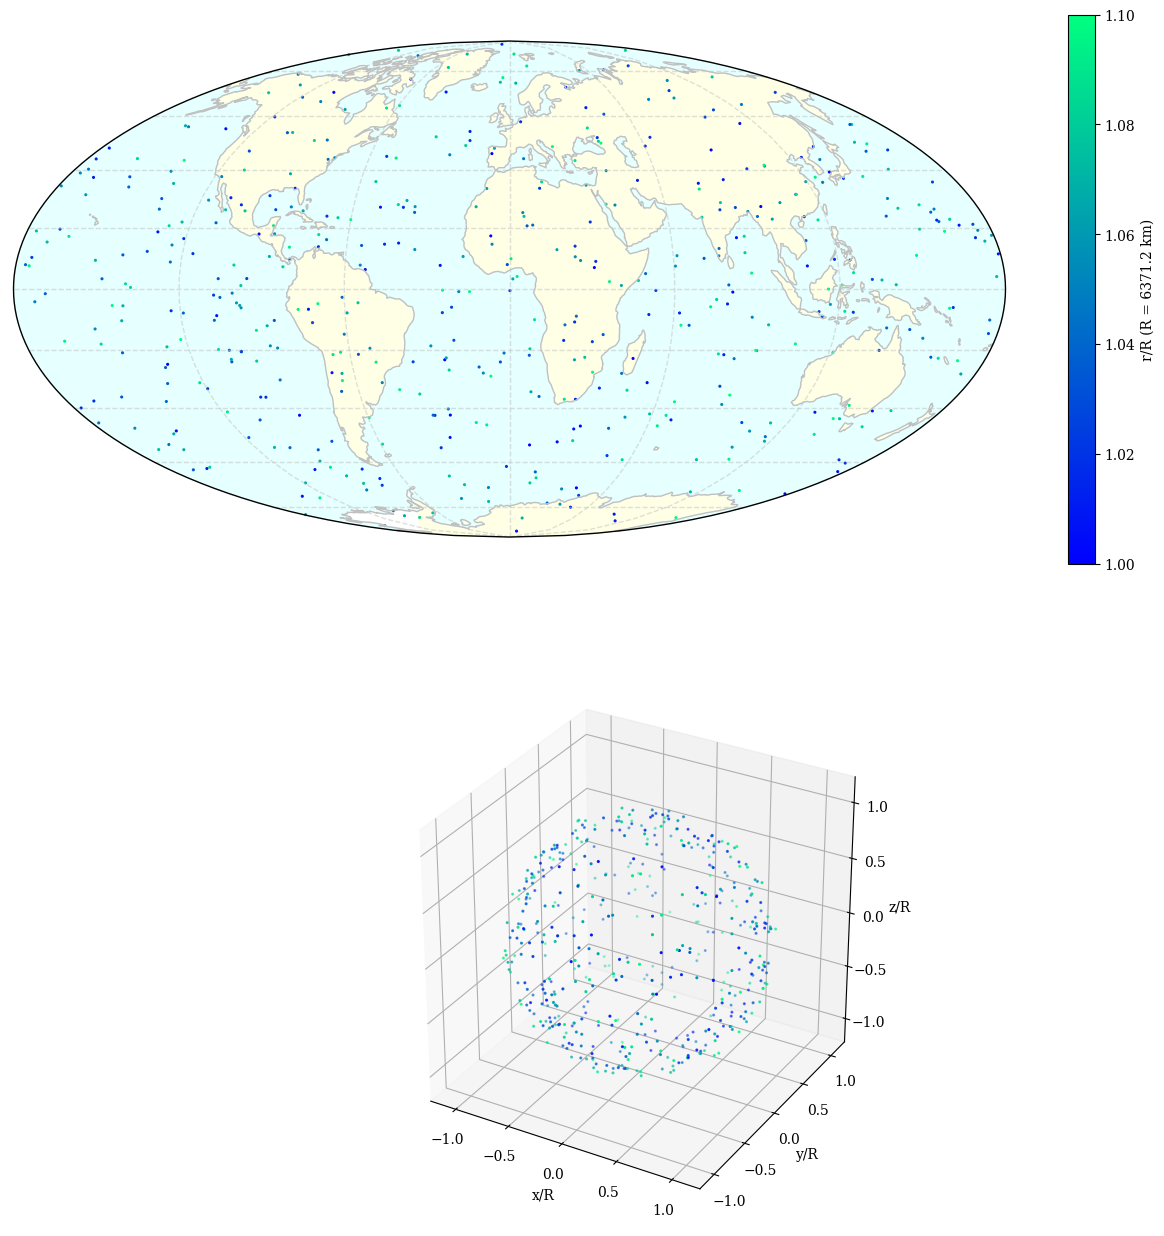

In [8]:
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, PlateCarree
from matplotlib import pyplot as plt
from matplotlib.cm import winter as colormap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.mplot3d import Axes3D
from eoxmagmod import convert, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
%matplotlib inline

norm = Normalize(vmin=1,vmax=1.1)

#help(ccrs)
fig = plt.figure(figsize=(16, 16), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1, projection=Mollweide())
gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=1, color='silver', alpha=0.5, linestyle='--')
ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
ax.add_feature(COASTLINE, edgecolor='silver')


obj = ax.scatter(
    lons, lats, c=rads/EARTH_RADIUS, s=1.5,
    cmap=colormap, norm=norm, transform=PlateCarree(),
     
)
cb = plt.colorbar(obj)
cb.ax.set_ylabel("r/R (R = %g km)" % EARTH_RADIUS)


ax = plt.subplot(2, 1, 2, projection='3d')

cart_coords = convert(coords, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN)/EARTH_RADIUS
obj = ax.scatter(
    cart_coords[:, 0], cart_coords[:, 1], cart_coords[:, 2], 
    c=rads/EARTH_RADIUS, s=1.5,
    cmap=colormap, norm=norm,
)

ax.set_aspect('equal','box')
ax.set_xlabel("x/R")
ax.set_ylabel("y/R")
ax.set_zlabel("z/R")

plt.show()